In [34]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [35]:
def synthetic_data(w, b, num_examples):
    # Example : tensor([ 0.9554, -0.7643, -0.2272, -2.6271,  0.2974,  1.0444])
    X = torch.normal(mean=0, std=1,size=(num_examples, len(w)))
    # X @ w : 矩阵乘法，tensor会把他们看作 1xn * n*1 得到一个标量, b 会使用广播机制  
    Y = X @ w + b
    # Y = torch.matmul(X, w) + b 
    # 加入噪声
    Y += torch.normal(mean=0, std=0.01,size=Y.shape)
    return X, Y.reshape((-1, 1))

In [36]:
true_w = torch.tensor([2, -3.4, 5, -3, 1,-2])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 10000)
dataset = [features, labels]
true_w.shape,true_w.size()

(torch.Size([6]), torch.Size([6]))

In [37]:
print('features: ', features[0], '\nlabels:',labels[0])

features:  tensor([ 0.2946, -1.3501, -0.3067,  0.5295,  0.1140, -1.6990]) 
labels: tensor([9.7745])


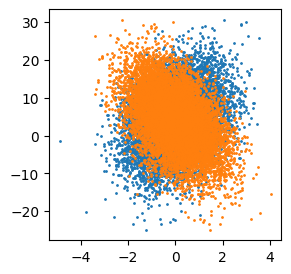

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(features[:,0].detach().numpy(), labels.detach().numpy(),1 ) # detach() 不使用计算图
plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(),1 ) # detach() 不使用计算图

In [39]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class MyDataset(Dataset):
    """
        if the dataset is small, we can load it into memory
        if the dataset is quite large, using the filename or fileindex as index
    """
    def __init__(self, dataset):
        # dataset=[X, y]是一个list，如果直接len(dataset)=2，所以我们需要使用X的len or X.shape[0]
        self.len = len(dataset[0])
        self.X = dataset[0]
        self.y = dataset[1]
    def __getitem__(self, index):
        """implement dataset[index]"""
        return self.X[index], self.y[index]
    def __len__(self):
        """len(batch) can return length"""
        return self.len
dataset = MyDataset([features, labels])
train_loader = DataLoader(dataset=dataset, batch_size=10,shuffle=True, num_workers=2)

In [40]:
# 模型参数
w = torch.normal(0, 0.01, size=true_w.shape, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [41]:
def net(X, w, b):
    return X @ w + b 

In [44]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [45]:
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降"""
    with torch.no_grad(): # 更新参数的时候梯度不需要参与计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [46]:
# training
def train(epochs, lr, batch_size):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader, 0):
            """(0, seq[0]), (1, seq[1]), (2, seq[2]), ..."""
            y_hat = net(x, w, b)
            loss = squared_loss(y, y_hat) 
            loss.sum().backward() # 这里的loss是一个vector
            sgd([w,b], lr, batch_size)
        with torch.no_grad():
            # 计算更新一个epoch的总loss，注意这个还没有区分训练集和测试集
            train_loss = squared_loss(labels, net(features, w, b))
            print(f'epoch {epoch + 1}, loss {float(train_loss.mean()):f}')
train(epochs=10,lr=0.03,batch_size=10)

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000052
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051


In [ ]:
# 查看与真实值的差距
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')